<a href="https://colab.research.google.com/github/Tclack88/DS-Unit-2-Applied-Modeling/blob/master/module2/assignment_applied_modeling_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 3, Module 2*

---


# Permutation & Boosting

You will use your portfolio project dataset for all assignments this sprint.

## Assignment

Complete these tasks for your project, and document your work.

- [x] Plot the distribution of your target. 
    - Classification problem: Are your classes imbalanced? Then, don't use just accuracy.
    - Regression problem: Is your target skewed? If so, let's discuss in Slack.
- [ ] Continue to clean and explore your data. Make exploratory visualizations.
- [x] Fit a model. Does it beat your baseline?
- [x] Try xgboost.
- [x] Get your model's permutation importances.

You should try to complete an initial model today, because the rest of the week, we're making model interpretation visualizations.


## Reading

Top recommendations in _**bold italic:**_

#### Permutation Importances
- _**[Kaggle / Dan Becker: Machine Learning Explainability](https://www.kaggle.com/dansbecker/permutation-importance)**_
- [Christoph Molnar: Interpretable Machine Learning](https://christophm.github.io/interpretable-ml-book/feature-importance.html)

#### (Default) Feature Importances
  - [Ando Saabas: Selecting good features, Part 3, Random Forests](https://blog.datadive.net/selecting-good-features-part-iii-random-forests/)
  - [Terence Parr, et al: Beware Default Random Forest Importances](https://explained.ai/rf-importance/index.html)

#### Gradient Boosting
  - [A Gentle Introduction to the Gradient Boosting Algorithm for Machine Learning](https://machinelearningmastery.com/gentle-introduction-gradient-boosting-algorithm-machine-learning/)
  - _**[A Kaggle Master Explains Gradient Boosting](http://blog.kaggle.com/2017/01/23/a-kaggle-master-explains-gradient-boosting/)**_
  - [_An Introduction to Statistical Learning_](http://www-bcf.usc.edu/~gareth/ISL/ISLR%20Seventh%20Printing.pdf) Chapter 8
  - [Gradient Boosting Explained](http://arogozhnikov.github.io/2016/06/24/gradient_boosting_explained.html)
  - _**[Boosting](https://www.youtube.com/watch?v=GM3CDQfQ4sw) (2.5 minute video)**_

In [1]:
import pandas as pd

url = "https://raw.githubusercontent.com/Tclack88/Renewable-Energy/master/power_plants.csv"
data = pd.read_csv(url)
data.head()

,plant_type,energy_source,prime_mover,year_built,lat,lon,total_power,n_units
0,Conventional Hydroelectric,WAT,HY,1963,33.458665,-87.35682,53.9,1
1,Natural Gas Steam Turbine,NG,ST,1954,31.006900,-88.01030,306.2,2
2,Natural Gas Steam Turbine,NG,ST,1954,31.006900,-88.01030,306.2,2
3,Conventional Steam Coal,BIT,ST,1969,31.006900,-88.01030,403.7,1
4,Conventional Steam Coal,BIT,ST,1971,31.006900,-88.01030,788.8,1


In [0]:
data = data.drop_duplicates()

## Target Distribution

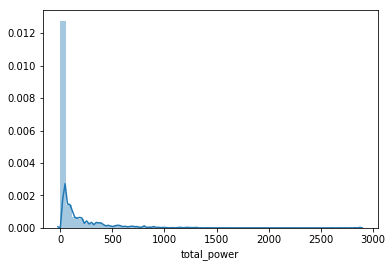

In [3]:
import seaborn as sb

sb.distplot(data.total_power);

There is a strong rightward skew, so it's best to encode the power as a logarithm (log(power+1))

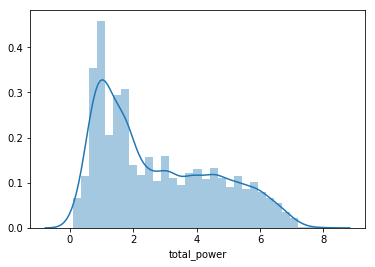

In [5]:
from numpy import log1p
import numpy as np
from scipy.stats import boxcox
# sb.distplot(boxcox(data.total_power)[0])
sb.distplot(log1p(data.total_power));

In [0]:
data['power_encoded'] = log1p(data.total_power)

## Baseline:
Neither the majority class (solar voltaic power output) nor the mean of all technologies seems to be a fair choice for the baseline, because power output can vary drastically between technologies (nuclear vs photovoltaic cells for example) so I propose using the mean of each technology for its own baseline

In [7]:
data.total_power.mean()

84.88152906935504

In [8]:
data.plant_type.value_counts()

Solar Photovoltaic                             2961
Conventional Hydroelectric                     2116
Petroleum Liquids                              2104
Natural Gas Fired Combined Cycle               1217
Onshore Wind Turbine                           1213
Natural Gas Fired Combustion Turbine           1132
Conventional Steam Coal                         628
Natural Gas Internal Combustion Engine          555
Natural Gas Steam Turbine                       517
Landfill Gas                                    503
Wood/Wood Waste Biomass                         306
Batteries                                       128
Other Waste Biomass                             125
Nuclear                                          90
Geothermal                                       87
Other Natural Gas                                76
All Other                                        74
Other Gases                                      72
Municipal Solid Waste                            72
Hydroelectri

In [9]:
data.groupby('plant_type').total_power.mean()

plant_type
All Other                                        22.439189
Batteries                                         7.616406
Coal Integrated Gasification Combined Cycle     332.466667
Conventional Hydroelectric                       37.753875
Conventional Steam Coal                         404.832006
Flywheels                                        11.750000
Geothermal                                       43.440230
Hydroelectric Pumped Storage                    352.762903
Landfill Gas                                      4.313718
Municipal Solid Waste                            36.411111
Natural Gas Fired Combined Cycle                248.165078
Natural Gas Fired Combustion Turbine            135.795760
Natural Gas Internal Combustion Engine            9.147207
Natural Gas Steam Turbine                       155.043907
Natural Gas with Compressed Air Storage         110.000000
Nuclear                                        1151.468889
Offshore Wind Turbine                        

In [10]:
mean_baselines = data.groupby('plant_type').total_power.mean().to_dict() # create dictionary for meanbaseline by tech
mean_baselines

{'All Other': 22.43918918918919,
 'Batteries': 7.616406249999999,
 'Coal Integrated Gasification Combined Cycle': 332.46666666666664,
 'Conventional Hydroelectric': 37.753875236294874,
 'Conventional Steam Coal': 404.83200636942667,
 'Flywheels': 11.75,
 'Geothermal': 43.44022988505746,
 'Hydroelectric Pumped Storage': 352.76290322580644,
 'Landfill Gas': 4.313717693836977,
 'Municipal Solid Waste': 36.411111111111104,
 'Natural Gas Fired Combined Cycle': 248.16507806080523,
 'Natural Gas Fired Combustion Turbine': 135.7957597173145,
 'Natural Gas Internal Combustion Engine': 9.147207207207208,
 'Natural Gas Steam Turbine': 155.04390715667304,
 'Natural Gas with Compressed Air Storage': 110.0,
 'Nuclear': 1151.4688888888888,
 'Offshore Wind Turbine': 30.0,
 'Onshore Wind Turbine': 81.13751030502888,
 'Other Gases': 40.2,
 'Other Natural Gas': 2.4578947368421056,
 'Other Waste Biomass': 6.7760000000000025,
 'Petroleum Coke': 77.09565217391305,
 'Petroleum Liquids': 16.690826996197703,
 

## Fit model

In [11]:
!pip install category_encoders
!pip install eli5

     |████████████████████████████████| 102kB 8.2MB/s 
     |████████████████████████████████| 112kB 8.7MB/s 


In [12]:
from sklearn.model_selection import train_test_split
import category_encoders as ce
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import eli5
from eli5.sklearn import PermutationImportance

Using TensorFlow backend.


In [0]:
labels = data.power_encoded
features = data.drop(columns= ['power_encoded','total_power'])

In [0]:
X_train,X_test,y_train,y_test = train_test_split(features,labels,random_state = 88)

In [0]:
rf = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                   RandomForestRegressor(n_estimators = 300,max_depth = 20,random_state=88))

In [16]:
rf.fit(X_train,y_train)

Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['plant_type', 'energy_source',
                                     'prime_mover'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, criterion='mse',
                                       max_depth=20, max_features='auto',
                                       max_leaf_nodes=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=300, n_jobs=None,
              

In [0]:
y_pred = rf.predict(X_test)

In [0]:
from numpy import expm1
y_pred = expm1(y_pred)

In [20]:
from sklearn.metrics import mean_absolute_error as mae

baseline_pred = np.array(X_test.plant_type.map(mean_baselines))

print("Mean Absolute Error with Baseline:\t\t ",mae(baseline_pred,expm1(y_test)))
print("Mean Absolute Error with random forest regressor:", mae(y_pred,expm1(y_test)))

Mean Absolute Error with Baseline:		  67.56847147264219
Mean Absolute Error with random forest regressor: 34.8729884046613


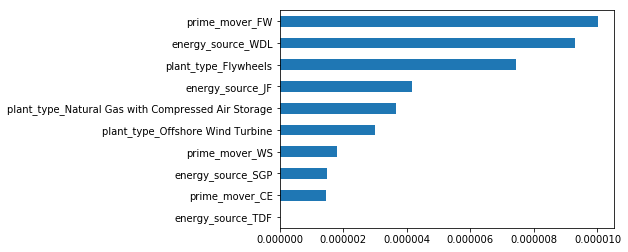

In [21]:
model = rf.named_steps['randomforestregressor']
feature_importances = model.feature_importances_
encoder = rf.named_steps['onehotencoder']
X_train_enc = encoder.transform(X_train)
features = X_train_enc.columns

pd.Series(feature_importances,features).sort_values(ascending=True)[:10].plot.barh();

### Permutation Importance and XGBoost

In [22]:
permuter = PermutationImportance(model,
                                 n_iter = 5,
                                 scoring = 'neg_mean_absolute_error')

X_test_enc = encoder.transform(X_test)
permuter.fit(X_test_enc,y_test)

PermutationImportance(cv='prefit',
                      estimator=RandomForestRegressor(bootstrap=True,
                                                      criterion='mse',
                                                      max_depth=20,
                                                      max_features='auto',
                                                      max_leaf_nodes=None,
                                                      min_impurity_decrease=0.0,
                                                      min_impurity_split=None,
                                                      min_samples_leaf=1,
                                                      min_samples_split=2,
                                                      min_weight_fraction_leaf=0.0,
                                                      n_estimators=300,
                                                      n_jobs=None,
                                                      oob_score=False,
   

In [23]:
features = X_test_enc.columns.to_list()
eli5.show_weights(permuter,
                  top=None,
                  feature_names = features)

Weight,Feature
0.4715 ± 0.0296,prime_mover_IC
0.3856 ± 0.0182,n_units
0.3158 ± 0.0189,year_built
0.1818 ± 0.0124,lat
0.1717 ± 0.0129,plant_type_Solar Photovoltaic
0.1535 ± 0.0079,prime_mover_PV
0.1522 ± 0.0150,lon
0.1376 ± 0.0125,plant_type_Natural Gas Fired Combined Cycle
0.0916 ± 0.0087,plant_type_Conventional Steam Coal
0.0829 ± 0.0079,prime_mover_HY


In [0]:
from xgboost import XGBRegressor

In [25]:
pipeline = make_pipeline(ce.OneHotEncoder(use_cat_names=True),
                         XGBRegressor(n_estimators = 100, n_jobs = -1, random_state = 88))

pipeline.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[06:44:09] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


Pipeline(memory=None,
         steps=[('onehotencoder',
                 OneHotEncoder(cols=['plant_type', 'energy_source',
                                     'prime_mover'],
                               drop_invariant=False, handle_missing='value',
                               handle_unknown='value', return_df=True,
                               use_cat_names=True, verbose=0)),
                ('xgbregressor',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0,
                              importance_type='gain', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=1,
                              missing=None, n_estimators=100, n_jobs=-1,
                              nthread=None, objective='reg:linear',
                              random_state=88, reg_alpha=0, reg_lambda=1,
               

In [0]:
xgb_pred = pipeline.predict(X_test)

In [27]:
xgb_pred = expm1(xgb_pred)
print('Mean Absolute Error with baseline:', mae(expm1(y_test),baseline_pred))
print('Mean Absolute Error with XGBoost:', mae(xgb_pred,expm1(y_test)))

Mean Absolute Error with baseline: 67.56847147264219
Mean Absolute Error with XGBoost: 50.645344747043616


RandomForest Regressor performed better than XGboost in this instance